# Deep Learning  Long Short-Term Memory (LSTM) 

## 1. Introduction
We will use deep learning methods by creating a neural network with memory  (LSTM)


## 2. Install/import libraries

In [ ]:
!pip install yfinance as yfinance

In [32]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
from datetime import date, timedelta
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

## 3. Download data

Download AstraZeneca historical data for 2010-2020 from Yahoo! Finance.

In [33]:
azn_df = yf.download("AZN.L", start="2010-01-01", end="2020-01-01")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%***********************]  1 of 1 completed


In [34]:
azn_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2009-12-31,1681.68,2913.5,2929.0,2892.00,2910.5,606488
2010-01-04,1699.30,2912.0,2946.0,2912.00,2941.0,2091679
2010-01-05,1679.94,2936.0,2949.5,2901.00,2907.5,2869739
2010-01-06,1661.16,2909.0,2909.0,2850.50,2875.0,3136541
2010-01-07,1681.68,2879.0,2925.5,2879.00,2910.5,3748200
...,...,...,...,...,...,...
2019-12-23,7210.13,7771.0,7824.0,7723.87,7746.0,2183949
2019-12-24,7180.35,7715.0,7794.0,7631.29,7714.0,378885
2019-12-27,7209.20,7706.0,7781.0,7641.00,7745.0,862283


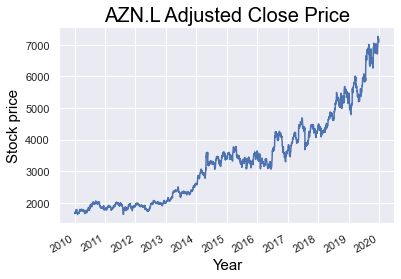

In [35]:
# Plot Adjusted Close price

azn_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## 4. Creating the Training and Test data

Generating multiple input and output data for model training as a  many-to-many data structure will enable us to forecast several time steps in the future. We will use the prices of the past X days to forecast those of the future Y days. In this example we will use the prices of the past 30 days (multiple inputs of 5 data points) to forecast the prices of the next 2 days (multiple outputs of 2 data points). 

**Samples** are created from the univariate time series and each sample has 30 inputs and 2 outputs. Each input of a sample is called the **time step**, and each time step has one **feature**, the Adjusted Close price.

The function below:
1.   creates a training set using 70% of the data and a test set using 30%.
2.   normalises the training data by converting the values of numeric columns in the dataset to a common scale, which helps the performance of the model. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1.
3. creates many-to-many input and output data structure for training and converts to numpy arrays for modelling.
4. reshapes the X_train data to a 3-D array with samples, time steps and feature dimensions
5. creates X_test data, converts to a numpy array and reshapes to 3-D array



In [36]:


def ts_train_test(data,time_steps,for_periods):
  
    # Create training and test set
    ts_train = azn_df[:'2016'].iloc[:,0:1].values
    ts_test  = azn_df['2017':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling - data normalisation - only the training data are used to fit the scaler transformation
    # MinMaxScaler scales all the data to be between 0 and 1.
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convert X_train and y_train to numpy arrays for training
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train to 3-D array of samples, time steps and features for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((azn_df["Adj Close"][:'2016'], azn_df["Adj Close"]['2017':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Creating X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    # Convert X_test to numpy array    
    X_test = np.array(X_test)
    # Reshape X_test to be 3-D
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

X_train, y_train, X_test, sc = ts_train_test(azn_df,30,2) # Each sample row in X_train has 30 inputs and y_train has 2 outputs
X_train.shape[0],X_train.shape[1]                        # as we are using the prices of 30 days to forecast the prices of the next 2 days 

(1738, 30)

In [37]:
# Convert the 3-D shape of X_train and y_train to a data frame 
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_df = pd.DataFrame(y_train)
pd.concat([X_train_df,y_train_df],axis=1)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,0,1
0,0.017093,0.023803,0.016430,0.009277,0.017093,0.016651,0.026884,0.021053,0.028423,0.041185,...,0.021602,0.021922,0.013360,0.000236,0.011193,0.019298,0.021922,0.022264,0.011307,0.015645
1,0.023803,0.016430,0.009277,0.017093,0.016651,0.026884,0.021053,0.028423,0.041185,0.036897,...,0.021922,0.013360,0.000236,0.011193,0.019298,0.021922,0.022264,0.011307,0.015645,0.012793
2,0.016430,0.009277,0.017093,0.016651,0.026884,0.021053,0.028423,0.041185,0.036897,0.040416,...,0.013360,0.000236,0.011193,0.019298,0.021922,0.022264,0.011307,0.015645,0.012793,0.014503
3,0.009277,0.017093,0.016651,0.026884,0.021053,0.028423,0.041185,0.036897,0.040416,0.051639,...,0.000236,0.011193,0.019298,0.021922,0.022264,0.011307,0.015645,0.012793,0.014503,0.015188
4,0.017093,0.016651,0.026884,0.021053,0.028423,0.041185,0.036897,0.040416,0.051639,0.048558,...,0.011193,0.019298,0.021922,0.022264,0.011307,0.015645,0.012793,0.014503,0.015188,0.022607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,0.813327,0.759631,0.734982,0.747386,0.746130,0.743620,0.739381,0.734198,0.734826,0.697145,...,0.720540,0.697305,0.731844,0.728390,0.758218,0.758534,0.727917,0.736711,0.730743,0.740166
1734,0.759631,0.734982,0.747386,0.746130,0.743620,0.739381,0.734198,0.734826,0.697145,0.685373,...,0.697305,0.731844,0.728390,0.758218,0.758534,0.727917,0.736711,0.730743,0.740166,0.760415
1735,0.734982,0.747386,0.746130,0.743620,0.739381,0.734198,0.734826,0.697145,0.685373,0.698558,...,0.731844,0.728390,0.758218,0.758534,0.727917,0.736711,0.730743,0.740166,0.760415,0.763557
1736,0.747386,0.746130,0.743620,0.739381,0.734198,0.734826,0.697145,0.685373,0.698558,0.727289,...,0.728390,0.758218,0.758534,0.727917,0.736711,0.730743,0.740166,0.760415,0.763557,0.766695


In [38]:
# Convert the 3-D shape of X_test to a data frame
X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_df)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.739381,0.734198,0.734826,0.697145,0.685373,0.698558,0.727289,0.710650,0.709865,0.679561,...,0.758218,0.758534,0.727917,0.736711,0.730743,0.740166,0.760415,0.763557,0.766695,0.769994
1,0.734198,0.734826,0.697145,0.685373,0.698558,0.727289,0.710650,0.709865,0.679561,0.657738,...,0.758534,0.727917,0.736711,0.730743,0.740166,0.760415,0.763557,0.766695,0.769994,0.770466
2,0.734826,0.697145,0.685373,0.698558,0.727289,0.710650,0.709865,0.679561,0.657738,0.649889,...,0.727917,0.736711,0.730743,0.740166,0.760415,0.763557,0.766695,0.769994,0.770466,0.782242
3,0.697145,0.685373,0.698558,0.727289,0.710650,0.709865,0.679561,0.657738,0.649889,0.643140,...,0.736711,0.730743,0.740166,0.760415,0.763557,0.766695,0.769994,0.770466,0.782242,0.805317
4,0.685373,0.698558,0.727289,0.710650,0.709865,0.679561,0.657738,0.649889,0.643140,0.644393,...,0.730743,0.740166,0.760415,0.763557,0.766695,0.769994,0.770466,0.782242,0.805317,0.805477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,1.959885,1.956339,1.946056,1.955631,1.995335,1.970164,1.946056,1.993914,1.968748,1.948185,...,1.939323,1.949602,1.936840,1.945348,1.966619,1.955631,1.935069,1.997814,2.017668,2.028301
752,1.956339,1.946056,1.955631,1.995335,1.970164,1.946056,1.993914,1.968748,1.948185,1.977256,...,1.949602,1.936840,1.945348,1.966619,1.955631,1.935069,1.997814,2.017668,2.028301,2.082896
753,1.946056,1.955631,1.995335,1.970164,1.946056,1.993914,1.968748,1.948185,1.977256,2.006322,...,1.936840,1.945348,1.966619,1.955631,1.935069,1.997814,2.017668,2.028301,2.082896,2.144578
754,1.955631,1.995335,1.970164,1.946056,1.993914,1.968748,1.948185,1.977256,2.006322,2.048155,...,1.945348,1.966619,1.955631,1.935069,1.997814,2.017668,2.028301,2.082896,2.144578,2.122599


In [39]:
# Print number of samples
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1738 samples in the training data
There are 756 samples in the test data


## 6. Long Short-Term Memory (LSTM)

LSTM structure retains memory for RNNs over longer time periods. It solves the problem of gradient vanishing (or gradient explosion) by introducing the concept of gates for controlling the flow of information in the network. Gates are capable of learning which inputs in the sequence are important and store their information in the memory unit. They can pass the information in long sequences and use them to make predictions. An LSTM has input, output and forget gates. 

It is called Long Short-Term Memory because it uses the short-term memory processes to create longer memory. LSTM has its own layers called the cell state, often labelled *Ct*, in addition to the hidden layers to prevent information from vanishing too soon.

An LSTM model will be implemented comprising two recurrent layers with 50 neurons, input shape of data with number of time steps (5) and dimensionality (1), and an output layer with time step of 2, and the tanh activation function. Dropout will be used after the second hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimiser, then fitted on the training set for 200 epochs with a batch size of 150.  



In [41]:
def LSTM_model(X_train, y_train, X_test, sc):  
  
    # The LSTM architecture
    my_LSTM_model = Sequential()
    # First LSTM layer 
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # Second LSTM layer 
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # Dropout regularisation
    my_LSTM_model.add(Dropout(0.2))
    # The output layer
    my_LSTM_model.add(Dense(units=2)) 

    # Compiling the LSTM
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error')

    # Fitting the LSTM to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=200,batch_size=64, verbose=0)

    # Make Predictions using the test set
    LSTM_predictions = my_LSTM_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)

    return my_LSTM_model, LSTM_predictions

my_LSTM_model, LSTM_predictions = LSTM_model(X_train, y_train, X_test, sc)
LSTM_predictions[1:10]

array([[3627.6763, 3619.9868],
       [3652.1648, 3644.7087],
       [3708.8118, 3702.364 ],
       [3721.4973, 3714.5945],
       [3758.6946, 3751.8267],
       [3801.75  , 3794.921 ],
       [3748.8948, 3739.4143],
       [3716.2979, 3705.1843],
       [3748.2957, 3737.844 ]], dtype=float32)

In [ ]:
def actual_pred_plot(preds):
 
   
    # Create dataframe containing actual and predicted prices
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = azn_df.loc['2017':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    # Calculate mean squared error
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    print("MSE score:", m.result().numpy())

    # Plot actual vs predicted price
    sns.set(rc={'figure.figsize':(15, 9)})
    actual_pred.plot()
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
    plt.legend()

### Print MSE and plot LSTM model actual vs predictions

MSE score: 31059.297


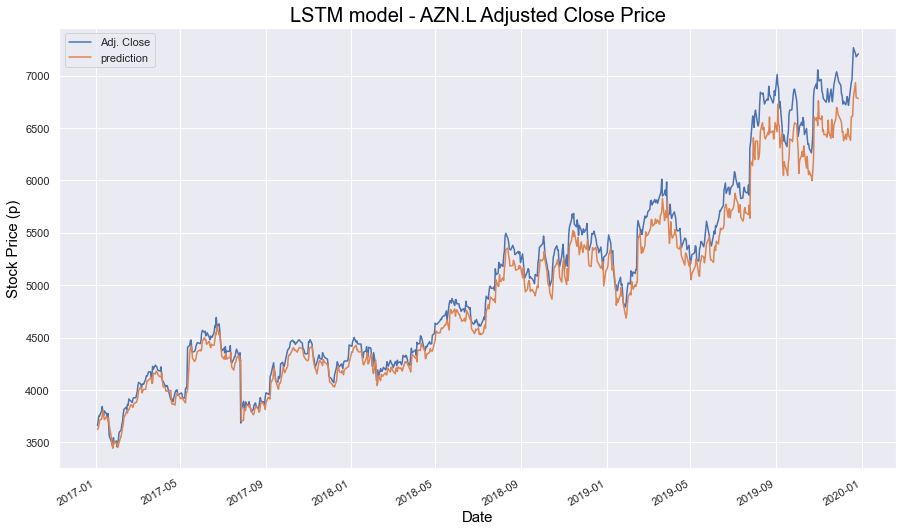

In [42]:
title_txt = 'LSTM model - AZN.L Adjusted Close Price'  

actual_pred_plot(LSTM_predictions)